# Clean Tweets Analysis

Tweets are scraped using the `baseline-user-ids.json` input (a list of User IDs) in `twitter_scraper.scrape`. To collect Tweets incrementally, the `scrape` module makes use of `since_id` and `max_id` paramaters issued by [Twitter API](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/api-reference/get-statuses-user_timeline).

All Tweets are filter by a given date interval, that is currently all Tweets from June 1st, 2022 (2022-06-01).


Tweets data schema:

Column                    | Description                                                           | Data Type
------------------------- | --------------------------------------------------------------------- | -------
id                        | Numeric Tweet identifier                                              | int64
created_at                | Date and time of Tweet creation                                       | datetime64[ns, UTC]
user_id                   | Tweet author                                                          | int64
full_text                 | Tweet full text                                                       | string
hashtags                  | Hashtags used in Tweet                                                | object
user_mentions             | Users mentioned in Tweet                                              | object
is_retweet                | Tweet is a Retweet                                                    | bool
retweet_created_at        | Date and time of Retweet creation                                     | datetime64[ns, UTC]
retweet_timedelta_sec     | Time elapsed between original Tweet and Retweet creation              | Int64 (nullable)
retweet_from_user_id      | Retweet author                                                        | Int64 (nullable)
retweet_from_tweet_id     | Numeric Retweet identifier                                            | Int64 (nullable)
is_reply                  | Tweet is a reply to another Tweet                                     | bool
in_reply_to_status_id     | Original Tweet ID if this Tweet is a reply                            | Int64 (nullable)
in_reply_to_user_id       | Original Tweet's User ID if this Tweet is a reply                     | Int64 (nullable)
is_quote_status           | Tweet is a quote                                                      | bool
favorite_count            | Number of times a Tweet was favorited (liked)                         | int64
possibly_sensitive        | Tweet contains sensitive content                                      | bool
week                      | Month of Tweet creation                                               | string
month                     | Week of Tweet creation                                                | string
langid                    | Tweet language                                                        | string

In [1]:
import matplotlib.style
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('seaborn-v0_8-darkgrid')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
from twitter_scraper import settings
from twitter_scraper import utils
from twitter_scraper.clean.users import USER_DTYPE
from twitter_scraper.clean.tweets import TWEET_DTYPE

import datetime as dt
import pandas as pd
from math import ceil


ANALYSIS_MIN_DATE = dt.datetime.fromisoformat('2022-11-01T00:00:00+00:00')

clean_users_dfs = utils.read_directory_files(
    directory=settings.CLEAN_USERS_DIR, 
    read_fn=pd.read_csv, 
    dtype=USER_DTYPE,
    parse_dates=['created_at']
)

clean_tweets_dfs = utils.read_directory_files(
    directory=settings.CLEAN_TWEETS_DIR, 
    read_fn=pd.read_csv, 
    dtype=TWEET_DTYPE,
    parse_dates=['created_at', 'retweet_created_at']
)

users_df = pd.concat(clean_users_dfs).set_index('user_id')
tweets_df = pd.concat(clean_tweets_dfs).drop_duplicates('id')
tweets_df = tweets_df.loc[tweets_df['created_at'] > ANALYSIS_MIN_DATE].drop_duplicates(subset='id')
tweets_df['year'] = tweets_df.created_at.dt.year
tweets_df['mon'] = tweets_df.created_at.dt.month
tweets_df['day'] = tweets_df.created_at.dt.day
tweets_df['is_retweet'] = tweets_df['is_retweet'].fillna(False)
tweets_df['is_reply'] = tweets_df['is_reply'].fillna(False)
unique_months = tweets_df.month.unique()

tweets__user_gdf = tweets_df.groupby('user_id').agg(
    total_tweets_cnt=('user_id', 'size'),
    retweet_tweets_cnt=('is_retweet', 'sum'),
    reply_tweets_cnt=('is_reply', 'sum'),
    quote_tweets_cnt=('is_quote_status', 'sum'),
    favorite_count=('favorite_count', 'sum')
)
tweets__user_gdf['original_tweets_cnt'] = tweets__user_gdf['total_tweets_cnt'] - (
    tweets__user_gdf['retweet_tweets_cnt'] + tweets__user_gdf['reply_tweets_cnt'] + tweets__user_gdf['quote_tweets_cnt']
)
tweets__user_gdf['original_tweets_cnt'] = tweets__user_gdf['original_tweets_cnt'].transform(lambda x: x if x > 0 else 0)
tweets__user_gdf['original_tweets_pct'] = tweets__user_gdf.apply(lambda row: \
    row.original_tweets_cnt / row.total_tweets_cnt if row.original_tweets_cnt > 0 else 0, axis=1)
tweets__user_gdf['retweet_tweets_pct'] = tweets__user_gdf['retweet_tweets_cnt'] / tweets__user_gdf['total_tweets_cnt']
tweets__user_gdf['reply_tweets_pct'] = tweets__user_gdf['reply_tweets_cnt'] / tweets__user_gdf['total_tweets_cnt']
tweets__user_gdf['quote_tweets_pct'] = tweets__user_gdf['quote_tweets_cnt'] / tweets__user_gdf['total_tweets_cnt']

users_df['total_tweets_cnt'] = tweets__user_gdf['total_tweets_cnt'].astype(int)
users_df['original_tweets_pct'] = tweets__user_gdf['original_tweets_pct'].fillna(0)
users_df['retweet_tweets_pct'] = tweets__user_gdf['retweet_tweets_pct'].fillna(0)
users_df['reply_tweets_pct'] = tweets__user_gdf['reply_tweets_pct'].fillna(0)
users_df['quote_tweets_pct'] = tweets__user_gdf['quote_tweets_pct'].fillna(0)
users_df = users_df.reset_index()

stats_df = pd.DataFrame(
    [
        '{:,}'.format(len(users_df[users_df.is_croatian == True])),
        '{:,}'.format(len(tweets_df.user_id.unique())),
        '{:,}'.format(len(tweets_df)),
        
        '{0:.2f}%'.format(users_df['original_tweets_pct'].mean()*100),
        '{0:.2f}%'.format(users_df['retweet_tweets_pct'].mean()*100),
        '{0:.2f}%'.format(users_df['reply_tweets_pct'].mean()*100),
        '{0:.2f}%'.format(users_df['quote_tweets_pct'].mean()*100),
        
        tweets_df['created_at'].min(),
        tweets_df['created_at'].max()

    ],
    index=[
        "Croatian Users (global) #",
        "Croatian Users (tweets) #",
        "Tweets #",
        
        "Original %",
        "Reweets %",
        "Replies %",
        "Quotes %",
        
        "Earliest Tweet date",
        "Latest Tweet date"
    ],
    columns=['Tweets Data']
)

stats_df

,Tweets Data
Croatian Users (global) #,"32,328"
Croatian Users (tweets) #,"6,188"
Tweets #,"294,653"
Original %,60.83%
Reweets %,15.24%
Replies %,18.90%
Quotes %,5.41%
Earliest Tweet date,2022-11-01 00:00:12+00:00
Latest Tweet date,2022-11-23 20:22:47+00:00


In [3]:
tweets_view = tweets_df[[
    'id',
    'hashtags',
    'user_mentions',
    'retweet_from_user_id',
    'retweet_from_status_id',
    'in_reply_to_user_id',
    'in_reply_to_status_id',
    'favorite_count',
    'lang',
    'user_id',
    'created_at',
    'retweet_created_at',
    'retweet_timedelta_sec',
    'is_quote_status',
    'year',
    'mon',
    'day',
    'is_retweet',
    'is_reply',
    'month',
    'week',
    'possibly_sensitive'
]].rename(
    columns={
        'langid': 'lang',
        'is_quote_status': 'is_quote'
    }
).merge(users_df[['user_id', 'screen_name', 'description', 'followers_count', 'friends_count']].rename(
    columns={
        'screen_name': 'user_name',
        'description': 'user_description',
        'followers_count': 'user_followers_count',
        'friends_count': 'user_friends_count',
    }), on='user_id'
)

tweets_view['hashtags'] = tweets_view['hashtags'].map(eval)
tweets_view['user_mentions'] = tweets_view['user_mentions'].map(eval)

in_reply_to_user_name = tweets_view[tweets_view['is_reply'] == True][[
    'in_reply_to_user_id'
]].reset_index().merge(users_df[['user_id', 'screen_name']].rename(
    columns={
        'user_id': 'in_reply_to_user_id',
        'screen_name': 'in_reply_to_user_name'
    }), how='left', on='in_reply_to_user_id'
).set_index('index')

retweet_from_user_name = tweets_view[tweets_view['is_retweet'] == True][[
    'retweet_from_user_id'
]].reset_index().merge(users_df[['user_id', 'screen_name']].rename(
    columns={
        'user_id': 'retweet_from_user_id',
        'screen_name': 'retweet_from_user_name'
    }), how='left', on='retweet_from_user_id'
).set_index('index')

# users_df = users_df.set_index('user_id')
# tweets_view['user_mentions'] = tweets_view['user_mentions'].transform(lambda x: [users_df.screen_name.get(user_mention_id, user_mention_id) for user_mention_id in x])
# users_df = users_df.reset_index()
tweets_view['reply_user_name'] = in_reply_to_user_name['in_reply_to_user_name']
tweets_view['reply_user_name'] = tweets_view['reply_user_name'].fillna(tweets_view['in_reply_to_user_id'].astype(str))
tweets_view['retweet_user_name'] = retweet_from_user_name['retweet_from_user_name']
tweets_view['retweet_user_name'] = tweets_view['retweet_user_name'].fillna(tweets_view['retweet_from_user_id'].astype(str))

tweets_view = tweets_view[[
    'id',
    'created_at', 
    'user_name', 
    'user_description',
    'user_followers_count',
    'lang', 
    'favorite_count',
    'is_retweet',
    'retweet_created_at',
    'retweet_timedelta_sec',
    'retweet_user_name',
    'is_reply',
    'reply_user_name',
    'is_quote',
    'hashtags', 
    'user_mentions', 
    'month', 
    'year',
    'mon',
    'day',
    'week', 
    'user_id',
    'possibly_sensitive'
]]
tweets_view.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294653 entries, 0 to 294652
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   id                     294653 non-null  int64              
 1   created_at             294653 non-null  datetime64[ns, UTC]
 2   user_name              294653 non-null  string             
 3   user_description       260583 non-null  string             
 4   user_followers_count   294653 non-null  int64              
 5   lang                   294653 non-null  object             
 6   favorite_count         294653 non-null  int64              
 7   is_retweet             294653 non-null  boolean            
 8   retweet_created_at     94632 non-null   datetime64[ns, UTC]
 9   retweet_timedelta_sec  94632 non-null   Int64              
 10  retweet_user_name      294653 non-null  string             
 11  is_reply               294653 non-null 

## Interpreting Croatian User Tweets

[Twitter API (user_timeline)](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/api-reference/get-statuses-user_timeline) contains limitations that disrupt some Analysis performed in "Clean Tweets Analysis". One limitation is that Twitter only allows collecting up to 3,200 of a user's most recent Tweets - making it ambiguous to analyse which users tweet the most in the collected Tweets network. Considreing this limitation, the "Clean Tweets Analysis" focuses on results that show information relations, rather than information quantity. 

To provide support for the listed limitation, the Data Ingestion pipeline is ran bi-weekly, assuming that a user will not post more than 3,200 tweets in a 2-week window. This assumption is analysed by providing a question:

* What is the maximum number of tweets per user in a 2-week window?

The "Clean Tweets Analysis" aims to create questions and provide answers based on a subset of available information (columns):

Column(s)                           | Questions
----------------------------------- | ----------------------------------------------
hashtags                            | - What are the most frequently used hashtags on a monthly basis?
hashtags + user_id                  | - What hashtags are linked to a user on average in total? <br> - What hashtags are linked to a user on average on a monthly basis?
user_mentions                       | - Who are the most frequently mentioned users on a monthly basis?
is_retweet + hashtags               | - What hashtags are used in retweets against original tweets in total? <br> - How do retweet hashtags correlate to original tweet hashtags?
is_retweet + user_id                | - What is the ratio between retweets and original tweets per top 10 tweeters on a monthly basis?
is_reply + is_retweet               | - What is the ratio between retweets, replies and original tweets?
is_reply + hashtags                 | - What hashtags are used in replies against original tweets in total? <br> - How do reply hashtags correlate to original tweet hashtags?
is_reply + user_id                  | - What is the ratio between replies and original tweets per top 10 tweeters on a monthly basis?
favorite_count + user_id            | - What users have the most favorite count in total? <br> - What users have the most favorite count on a monthly basis?
favorite_count + hashtags           | - What hashtags have the most favorite count in total? <br> - What hashtags have the most favorite count on a monthly basis?
retweet_timedelta_sec               | - What is the average retweet_timedelta_sec?
retweet_timedelta_sec + user_id     | - What users retweet the fastest?
retweet_timedelta_sec + hashtags    | - What hashtags are retweeted the fastest?

In [4]:
tweets_view[['created_at', 'user_name', 'is_retweet', 'is_reply', 'user_followers_count', 'favorite_count', 'hashtags', 'user_mentions']].sort_values(['favorite_count', 'user_followers_count'], ascending=False).head(1000).sample(10)

,created_at,user_name,is_retweet,is_reply,user_followers_count,favorite_count,hashtags,user_mentions
125123,2022-11-15 13:51:55+00:00,AntifaVjesnik,False,False,4921,330,[],[]
27431,2022-11-19 15:49:32+00:00,EPavlic,False,True,5030,243,[],"[44196397, 1092037021432897537]"
187588,2022-11-02 18:01:48+00:00,SpectatorHR,False,False,2151,131,[],[]
43969,2022-11-07 12:22:31+00:00,petrov_aco,False,False,6590,207,[],[]
149693,2022-11-01 17:32:27+00:00,Fattamorggana,False,False,1506,515,[],[]
109419,2022-11-07 11:18:33+00:00,llandonorris,False,False,664,127,[],[]
221744,2022-11-12 03:41:42+00:00,jimkeFN,False,False,4777,226,[],"[1050120173296979968, 479547636]"
160531,2022-11-18 08:12:23+00:00,nationofcroats,False,False,1896,184,[],[]
183402,2022-11-16 18:52:08+00:00,HNS_CFF,False,False,253625,311,"[WorldCup, Obitelj, Vatreni]",[]
85494,2022-11-20 18:48:10+00:00,NikolaCizmesija,False,False,34977,406,[],[]


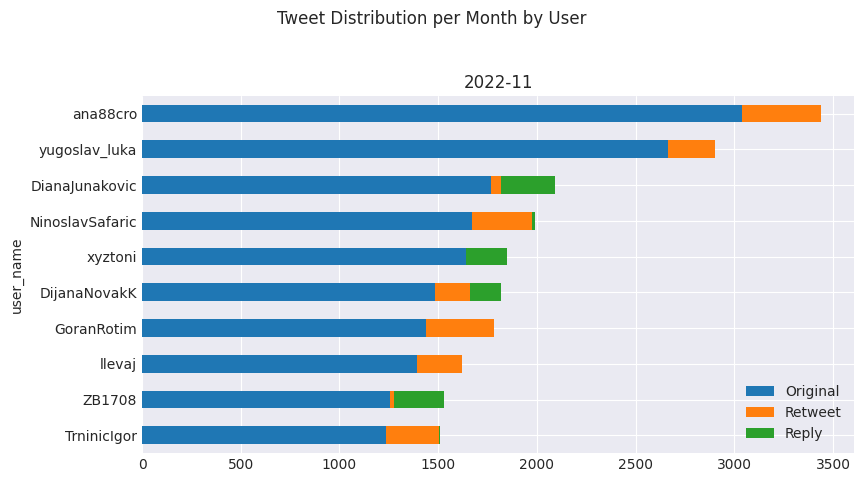

In [14]:
unique_months = tweets_view.month.unique()
fig, axs = plt.subplots(len(unique_months), figsize=(9, len(unique_months) * 5), squeeze=False)

plt.suptitle('Tweet Distribution per Month by User')

top_tweeters = tweets_view[[
    'id', 'month', 'user_name', 'is_retweet', 'is_reply', 'is_quote', 'user_followers_count'
]].groupby(['month', 'user_name']).agg(
    total_tweets_cnt=('id', 'size'),
    retweet_tweets_cnt=('is_retweet', 'sum'),
    reply_tweets_cnt=('is_reply', 'sum'),
    quote_tweets_cnt=('is_quote', 'sum')
)
top_tweeters['original_tweets_cnt'] = top_tweeters['total_tweets_cnt'] - (
    top_tweeters['retweet_tweets_cnt'] + top_tweeters['reply_tweets_cnt']
)
max_tweets = top_tweeters['total_tweets_cnt'].max()

for i, month in enumerate(unique_months[::-1]):

    gdf = top_tweeters.loc[month].sort_values('total_tweets_cnt')
    gdf[['original_tweets_cnt', 'retweet_tweets_cnt', 'reply_tweets_cnt']].tail(10).rename(
        columns={
            'original_tweets_cnt': 'Original',
            'retweet_tweets_cnt': 'Retweet',
            'reply_tweets_cnt': 'Reply'
        }
    ).plot.barh(ax=axs[i][0], stacked=True)
    axs[i][0].set_title(month)
    axs[i][0].set_xlim(xmin=0)

fig.tight_layout(pad=2)
plt.show()


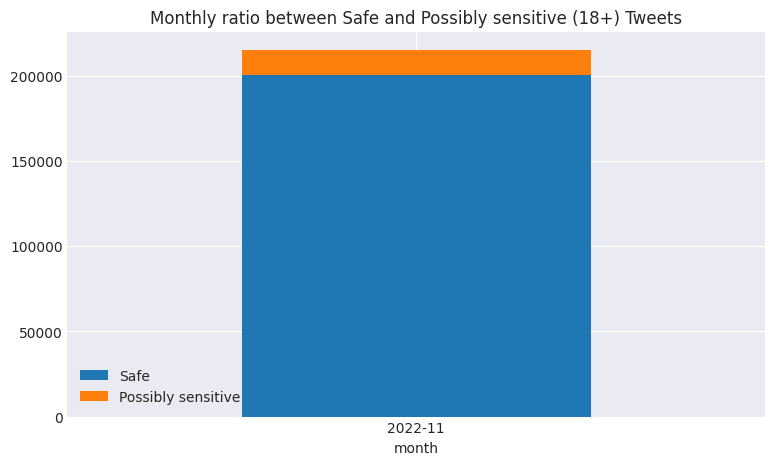

In [17]:
fig, ax = plt.subplots(1, figsize=(9, 5))

tweets_df_pivot = tweets_df[['month', 'possibly_sensitive', 'id']].pivot_table(index='month', columns=['possibly_sensitive'], aggfunc=len)
tweets_df_pivot.plot.bar(ax=ax, rot=0, stacked=True)

ax.set_title('Monthly ratio between Safe and Possibly sensitive (18+) Tweets')
ax.legend(['Safe', 'Possibly sensitive'])
plt.show()

# Favorites

In [18]:
favorites_view = tweets_view.groupby(['month', 'user_name', 'possibly_sensitive']).agg(
    tweets_num=('id', 'size'),
    favorite_count=('favorite_count', 'sum'),
    hashtags=('hashtags', 'sum')
)
favorites_view

tweets_num  favorite_count  \
month   user_name possibly_sensitive                               
2022-11 01Cro     False                        1               1   
                  True                         1              76   
        0212biker False                       30             147   
        0408zzzz  False                       31              26   
        09Nenad   False                       30              95   
...                                          ...             ...   
        zvpomir   False                       10               8   
        zwoone    False                       58              10   
        zyrdack   False                        1              13   
        zytzagoo  False                        1               0   
        zzavrski  False                        1               1   

                                                                               hashtags  
month   user_name possibly_sensitive                                                     
2022-11 01Cro     False                                                              []  
                  True                                                               []  
        0212biker False                                                              []  
        0408zzzz  False                                                              []  
        09Nenad   False                                                        [đećemo]  
...                                                                                 ...  
        zvpomir   False                                                              []  
        zwoone    False               [writerslift, writerslift, wip, book, novel, d...  
        zyrdack   False                                                              []  
        zytzagoo  False                                                              []  
        zzavrski  False                                                              []  

[6007 rows x 3 columns]

## possibly_sensitive + favorite_count
  - What kind of content has most favorite counts?

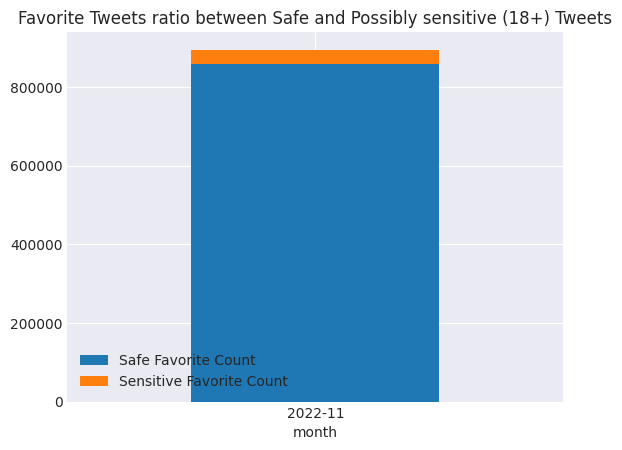

In [19]:
title = 'Favorite Tweets ratio between Safe and Possibly sensitive (18+) Tweets'

ax = favorites_view.groupby(['month', 'possibly_sensitive']).agg(
    favorite_count=('favorite_count', 'sum')
).reset_index().pivot(
    index='month', 
    columns=['possibly_sensitive']
).plot.bar(stacked=True, title=title, rot=0)
ax.legend(['Safe Favorite Count', 'Sensitive Favorite Count'], title=None)
plt.show()

## month + user_id + favorite_count
  - What users have the most favorite count in total?

In [20]:
import ipywidgets as widgets
from ipywidgets import GridspecLayout

top = 20
title = 'Top {} Users with most Favorite Count in Total'.format(top)

gdf = favorites_view.groupby('user_name').agg(
    favorite_count=('favorite_count', 'sum')
).sort_values('favorite_count', ascending=False).rename(
            columns={'favorite_count': 'Favorite Count'}
        )

out_box1 = widgets.Output(layout={"border":"1px solid green"})
out_box2 = widgets.Output(layout={"border":"1px solid green"})

with out_box1:
    ax = gdf.head(top)[::-1].plot.barh(rot=0, title=title, figsize=(6, 10))
    ax.set_ylabel(None)
    plt.show()
    
with out_box2:
    pd.set_option('display.max_colwidth', 180)
    display(
        gdf.join(users_df[['screen_name', 'name', 'description']].set_index('screen_name')).rename(
            columns={'description': 'Description', 'name': 'Name'}
        )[['Name', 'Description', 'Favorite Count']].head(top)
    )


grid = GridspecLayout(1, 10)
grid[:, 0:4] = out_box1
grid[:, 4:10] = out_box2

display(grid)

GridspecLayout(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', …

- What kind of communities are people with a greater number of favorites sorrounded with?

  - What users have the most favorite count on a monthly basis?

In [ ]:
gdf

,Favorite Count
user_name,
Perkz,364903
mislavkolakusic,122191
HNS_CFF,78328
Professeur_CS,73276
UltimateEgoist,68571
...,...
Eve_266_,0
dsohar,0
dstenc,0


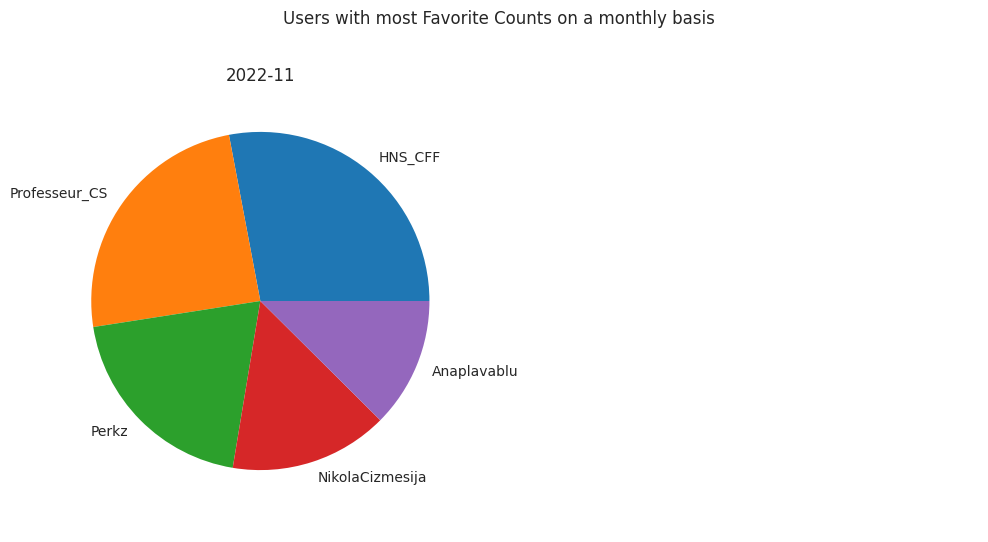

In [21]:
ncols = 2
nrows = ceil(len(unique_months)/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*6, nrows*6), squeeze=False)

plt.suptitle('Users with most Favorite Counts on a monthly basis')

gdf = favorites_view.groupby(['month', 'user_name']).agg(
    favorite_count=('favorite_count', 'sum')
).sort_values(['month', 'favorite_count'], ascending=False).rename(
    columns={'favorite_count': 'Favorite Count'}
)

i, j = 0, 0
for month in unique_months:
    if j == ncols: j = 0; i += 1

    gdf.loc[month].head(5).plot(kind='pie', y='Favorite Count', ax=axs[i][j], legend=None)
    axs[i][j].set_title(month)
    axs[i][j].set_ylabel(None)
    
    j += 1

plt.axis('off')
plt.show()

- How does the number of favorites change through time as the user gets more followers?

## month + favorite_count + hashtags
  - What hashtags have the most favorite count in total?
  - What hashtags have the most favorite count on a monthly basis?

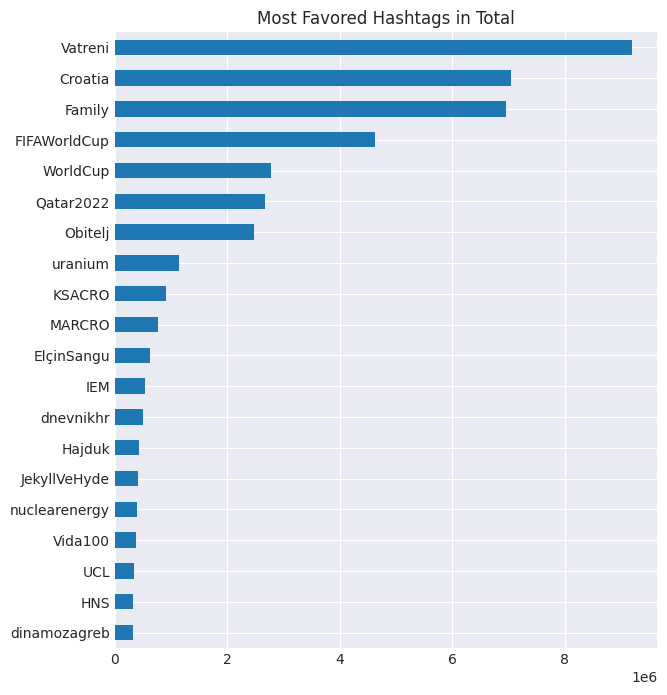

In [22]:
import warnings
warnings.filterwarnings('ignore')

ax = favorites_view[['favorite_count', 'hashtags']].explode(
    ['hashtags']
).dropna().groupby('hashtags').agg(
    favorite_count=('favorite_count', 'sum')
).sort_values('favorite_count', ascending=False).head(20)[::-1] \
 .plot(kind='barh', y='favorite_count', legend=None, figsize=(7, 8))

ax.set_ylabel(None)
ax.set_title('Most Favored Hashtags in Total')
plt.show()

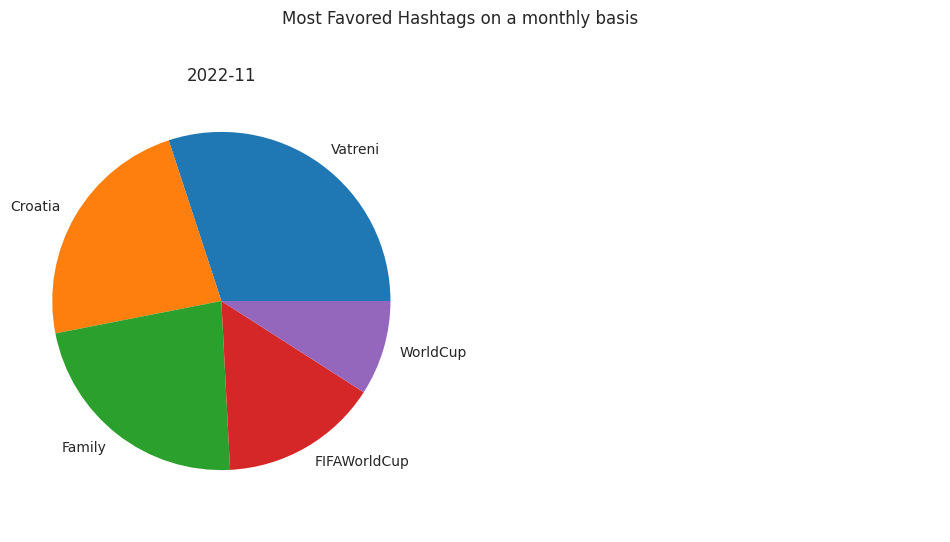

In [23]:
ncols = 2
nrows = ceil(len(unique_months) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6), squeeze=False)
plt.suptitle('Most Favored Hashtags on a monthly basis')

gdf = favorites_view[['favorite_count', 'hashtags']].explode(
    ['hashtags']
).dropna().groupby(['month', 'hashtags']).agg(
    favorite_count=('favorite_count', 'sum')
).sort_values(['month', 'favorite_count'], ascending=False).rename(
    columns={'favorite_count': 'Favorite Count'}
)

max_favorite_count = max(gdf['Favorite Count']) + 10000

i, j = 0, 0
for month in unique_months:
    if j == ncols: j = 0; i += 1

    gdf.loc[month].head(5).plot(kind='pie', y='Favorite Count', ax=axs[i][j], legend=None)
    axs[i][j].set_title(month)
    axs[i][j].set_ylabel(None)
    
    j += 1

plt.axis('off')
plt.show()

# Hashtags

In [24]:
hashtags_view = tweets_view[['id', 'user_name', 'year', 'mon', 'month', 'hashtags', 'is_retweet', 'is_reply', 'favorite_count']].explode('hashtags').dropna()
hashtags_view.sample(10)

,id,user_name,year,mon,month,hashtags,is_retweet,is_reply,favorite_count
97537,1588587343120068609,NKIstra1961,2022,11,2022-11,ForzaIstra,False,False,1
91453,1594501362041212930,227gaming,2022,11,2022-11,AEWFullGear,True,False,0
45155,1588057797421400067,MovArturoIstria,2022,11,2022-11,Radiazione,False,False,1
148310,1595369290810757121,DRDevourer,2022,11,2022-11,FIFAWorldCup,False,False,0
232105,1594897405358505985,PiskorMario,2022,11,2022-11,photography,True,False,0
191245,1593575758487863299,giov_vale,2022,11,2022-11,itsraining,False,False,3
184701,1589528377098211328,agroklub,2022,11,2022-11,traktor,False,False,0
273393,1587881718643556353,Herochange133,2022,11,2022-11,今夜もウルトラ,False,False,0
34412,1594928293920260096,ab66ab24,2022,11,2022-11,CanYaman,False,False,38
294629,1595175440062287904,robertsimicart,2022,11,2022-11,VFX,True,False,0


## month + hashtags
- What are the most frequently used hashtags in total? How are they distributed in retweets, replies and original tweets?


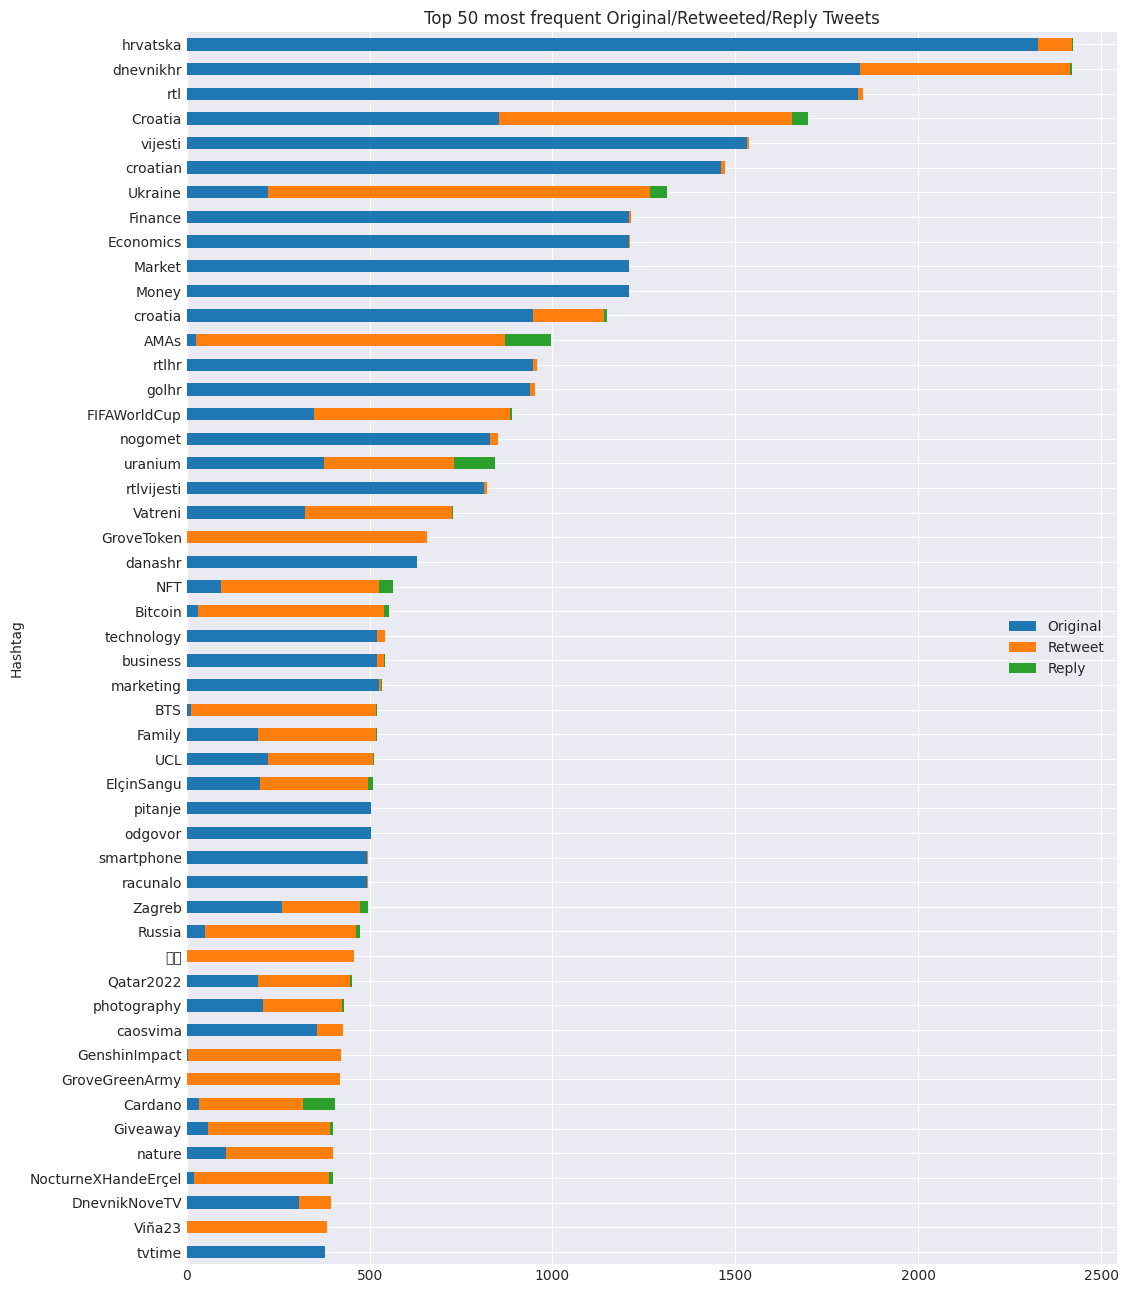

In [ ]:
agg_hashtags_view = hashtags_view.groupby('hashtags').agg(
    total=('hashtags', 'size'),
    is_retweet=('is_retweet', 'sum'),
    is_reply=('is_reply', 'sum')
).sort_values('total', ascending=False)
agg_hashtags_view['original'] = agg_hashtags_view['total'] - (agg_hashtags_view['is_retweet'] + agg_hashtags_view['is_reply'])

ax = agg_hashtags_view[['original', 'is_retweet', 'is_reply']].rename(columns={
  'original': 'Original',
  'is_retweet': 'Retweet',
  'is_reply': 'Reply'
}).head(50)[::-1].plot.barh(stacked=True, figsize=(12, 16))

ax.set_title('Top 50 most frequent Original/Retweeted/Reply Tweets')
ax.set_ylabel("Hashtag")
ax.legend(loc='center right')
plt.show()

- What are the most frequently used hashtags on a monthly basis? How are they distributed in retweets, replies and original tweets?

In [25]:
month_hashtags_view = hashtags_view.groupby(['year', 'mon', 'hashtags']).agg(
    favorite_count=('favorite_count', 'sum'),
    total=('hashtags', 'size'),
    is_retweet=('is_retweet', 'sum'),
    is_reply=('is_reply', 'sum')
).sort_values(['year', 'mon', 'total'], ascending=False)
month_hashtags_view['original'] = month_hashtags_view['total'] - (month_hashtags_view['is_retweet'] + month_hashtags_view['is_reply'])
month_hashtags_view

favorite_count  total  is_retweet  is_reply  original
year mon hashtags                                                            
2022 11  hrvatska                  815    982          14         0       968
         Croatia                 44628    912         335         8       569
         FIFAWorldCup            20220    873         487         4       382
         dnevnikhr                 641    868         124         0       744
         rtl                       172    759           1         0       758
...                                ...    ...         ...       ...       ...
         𝗖𝗮𝗿𝗮𝗯𝗮𝗼𝗖𝘂𝗽                  0      1           0         0         1
         𝗠𝗮𝗻𝗖𝗶𝘁𝘆                     0      1           0         0         1
         𝗯𝗮𝗿𝗲𝗯𝗮𝗰𝗸                    0      1           1         0         0
         𝙘𝙧𝙤𝙝𝙖𝙣𝙙𝙗𝙖𝙡𝙡                 3      1           0         0         1
         𝙶𝚛𝚘𝚞𝚙𝚂𝚝𝚞𝚍𝚢3️⃣               0      1           0         0         1

[25852 rows x 5 columns]

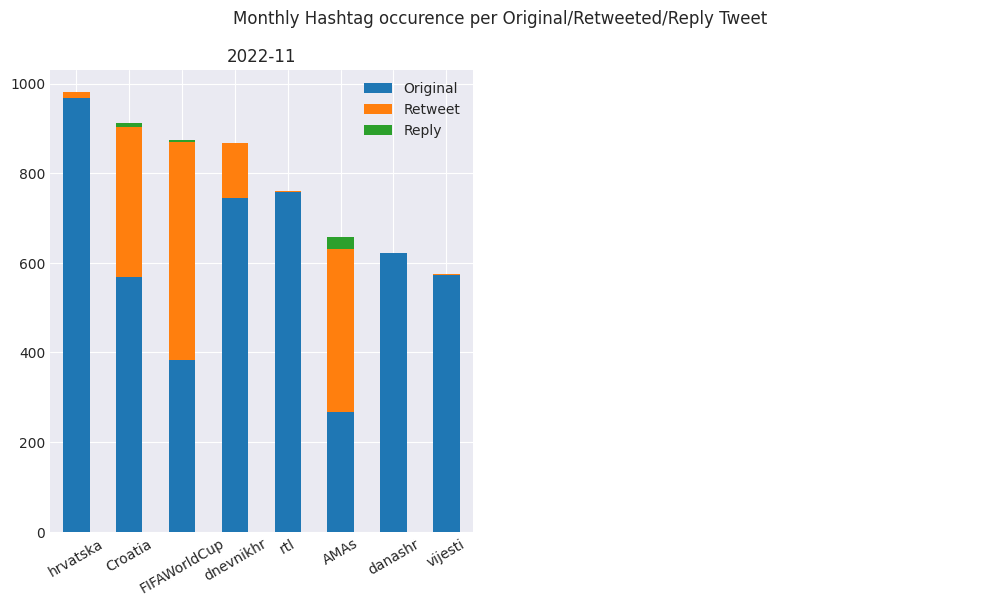

In [26]:
ncols = 2
nrows = ceil(len(unique_months) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6), squeeze=False)
plt.suptitle("Monthly Hashtag occurence per Original/Retweeted/Reply Tweet")

month_hashtags = month_hashtags_view[['original', 'is_retweet', 'is_reply']].rename(columns={
    'original': 'Original',
    'is_retweet': 'Retweet',
    'is_reply': 'Reply'
})

i, j = 0, 0
for month in unique_months:
    if j == ncols: j = 0; i += 1
    
    year, mon = tuple(map(int, month.split('-')))
    plot_df = month_hashtags.loc[(year, mon)]
    plot_df.head(8).plot.bar(ax=axs[i][j], stacked=True, rot=30)
    axs[i][j].set_title(month)
    # ax.set_ylabel(month)
    axs[i][j].set_xlabel(None)
    
    j += 1

if len(unique_months) % ncols != 0:
    plt.axis('off')
plt.show()

In [27]:
def get_hashtags_groupby(df, groupby=['hashtags', 'year', 'mon', 'user_name']):
    hashtags_groupby = df.groupby(groupby).agg(
        favorite_count=('favorite_count', 'sum'),
        is_retweet=('is_retweet', 'sum'), 
        is_reply=('is_reply', 'sum'),
        user_hashtag_cnt=('user_name', 'size')
    )

    total_hashtag_cnt_view = df.groupby(['hashtags', 'year', 'mon']).size()

    gdf = hashtags_groupby.copy()
    gdf['total_hashtag_cnt'] = gdf.index.to_series().apply(lambda x: total_hashtag_cnt_view.loc[(x[0], x[1], x[2])])
    gdf['user_hashtag_pct'] = gdf['user_hashtag_cnt'] / gdf['total_hashtag_cnt']
    gdf['avg_user_hashtag_pct'] = gdf.index.to_series().apply(lambda x: gdf.loc[(x[0], x[1], x[2]), 'user_hashtag_pct'].mean())
    return gdf.sort_index()

# hashtags_user_month_groupby = get_hashtags_groupby(hashtags_view, ['hashtags', 'user_name', 'year', 'mon'])
# hashtags_user_month_groupby[hashtags_user_month_groupby['user_hashtag_pct'] != 1].sort_values('is_retweet', ascending=False).head(30)
hashtags_groupby = get_hashtags_groupby(hashtags_view, ['hashtags', 'year', 'mon', 'user_name'])
#hashtags_groupby.loc[(hashtags_groupby.index.get_level_values('hashtags').isin(('SlavaUkraini', 'hrvatska', 'dnevnikhr')), slice(None))][180:240].head(60)#.sort_values('user_hashtag_pct', ascending=False).head(30)
hashtags_groupby

favorite_count  is_retweet  is_reply  \
hashtags      year mon user_name                                           
0day          2022 11  bebinjo                   0           0         0   
1000XGEMS     2022 11  Crobot01                  0           0         0   
1000Xgems     2022 11  TrninicIgor               0           1         0   
1000x         2022 11  Crobot01                  0           0         0   
                       TrninicIgor               0           0         0   
...                                            ...         ...       ...   
𝗖𝗮𝗿𝗮𝗯𝗮𝗼𝗖𝘂𝗽    2022 11  MikicVedran               0           0         0   
𝗠𝗮𝗻𝗖𝗶𝘁𝘆       2022 11  MikicVedran               0           0         0   
𝗯𝗮𝗿𝗲𝗯𝗮𝗰𝗸      2022 11  skycrohr                  0           1         0   
𝙘𝙧𝙤𝙝𝙖𝙣𝙙𝙗𝙖𝙡𝙡   2022 11  HRStwitt                  3           0         0   
𝙶𝚛𝚘𝚞𝚙𝚂𝚝𝚞𝚍𝚢3️⃣ 2022 11  RMalvic                   0           0         0   

                                    user_hashtag_cnt  total_hashtag_cnt  \
hashtags      year mon user_name                                          
0day          2022 11  bebinjo                     1                  1   
1000XGEMS     2022 11  Crobot01                    1                  1   
1000Xgems     2022 11  TrninicIgor                 1                  1   
1000x         2022 11  Crobot01                    1                  2   
                       TrninicIgor                 1                  2   
...                                              ...                ...   
𝗖𝗮𝗿𝗮𝗯𝗮𝗼𝗖𝘂𝗽    2022 11  MikicVedran                 1                  1   
𝗠𝗮𝗻𝗖𝗶𝘁𝘆       2022 11  MikicVedran                 1                  1   
𝗯𝗮𝗿𝗲𝗯𝗮𝗰𝗸      2022 11  skycrohr                    1                  1   
𝙘𝙧𝙤𝙝𝙖𝙣𝙙𝙗𝙖𝙡𝙡   2022 11  HRStwitt                    1                  1   
𝙶𝚛𝚘𝚞𝚙𝚂𝚝𝚞𝚍𝚢3️⃣ 2022 11  RMalvic                     1                  1   

                                    user_hashtag_pct  avg_user_hashtag_pct  
hashtags      year mon user_name                                            
0day          2022 11  bebinjo                   1.0                   1.0  
1000XGEMS     2022 11  Crobot01                  1.0                   1.0  
1000Xgems     2022 11  TrninicIgor               1.0                   1.0  
1000x         2022 11  Crobot01                  0.5                   0.5  
                       TrninicIgor               0.5                   0.5  
...                                              ...                   ...  
𝗖𝗮𝗿𝗮𝗯𝗮𝗼𝗖𝘂𝗽    2022 11  MikicVedran               1.0                   1.0  
𝗠𝗮𝗻𝗖𝗶𝘁𝘆       2022 11  MikicVedran               1.0                   1.0  
𝗯𝗮𝗿𝗲𝗯𝗮𝗰𝗸      2022 11  skycrohr                  1.0                   1.0  
𝙘𝙧𝙤𝙝𝙖𝙣𝙙𝙗𝙖𝙡𝙡   2022 11  HRStwitt                  1.0                   1.0  
𝙶𝚛𝚘𝚞𝚙𝚂𝚝𝚞𝚍𝚢3️⃣ 2022 11  RMalvic                   1.0                   1.0  

[43953 rows x 7 columns]

In [28]:
hashtags_groupby.loc['Vatreni'].sort_values('user_hashtag_pct', ascending=False)

favorite_count  is_retweet  is_reply  \
year mon user_name                                             
2022 11  HNS_CFF                 47575           1         0   
         NeovisniA                   0          42         0   
         CroatiaFooty              469          10         0   
         lojzini                     0          11         0   
         Tonko35                     0          14         0   
...                                ...         ...       ...   
         LikeZadar                   0           1         0   
         Laila_Horvat                0           1         0   
         KsenijaKardum               0           1         0   
         KolindaGK                 132           0         0   
         RoguljM                     4           0         0   

                        user_hashtag_cnt  total_hashtag_cnt  user_hashtag_pct  \
year mon user_name                                                              
2022 11  HNS_CFF                     176                558          0.315412   
         NeovisniA                    48                558          0.086022   
         CroatiaFooty                 24                558          0.043011   
         lojzini                      15                558          0.026882   
         Tonko35                      14                558          0.025090   
...                                  ...                ...               ...   
         LikeZadar                     1                558          0.001792   
         Laila_Horvat                  1                558          0.001792   
         KsenijaKardum                 1                558          0.001792   
         KolindaGK                     1                558          0.001792   
         RoguljM                       1                558          0.001792   

                        avg_user_hashtag_pct  
year mon user_name                            
2022 11  HNS_CFF                     0.00813  
         NeovisniA                   0.00813  
         CroatiaFooty                0.00813  
         lojzini                     0.00813  
         Tonko35                     0.00813  
...                                      ...  
         LikeZadar                   0.00813  
         Laila_Horvat                0.00813  
         KsenijaKardum               0.00813  
         KolindaGK                   0.00813  
         RoguljM                     0.00813  

[123 rows x 7 columns]

In [29]:
hashtags_groupby.loc['croatia'].sort_values('user_hashtag_pct', ascending=False)

favorite_count  is_retweet  is_reply  \
year mon user_name                                               
2022 11  ICTracunalo                  48           0         0   
         PIXSELL                     392           0         0   
         nenadzanko                   64           0         0   
         z_grgic96                   119           0         0   
         nauticalcroatia               1           0         0   
...                                  ...         ...       ...   
         ParametarSplit                0           1         0   
         OrkoZg                        0           0         0   
         NoaBeachClub                  2           0         0   
         NinoslavSafaric               0           0         0   
         zvonimirVK                    2           0         0   

                          user_hashtag_cnt  total_hashtag_cnt  \
year mon user_name                                              
2022 11  ICTracunalo                   207                509   
         PIXSELL                        87                509   
         nenadzanko                     23                509   
         z_grgic96                      13                509   
         nauticalcroatia                 8                509   
...                                    ...                ...   
         ParametarSplit                  1                509   
         OrkoZg                          1                509   
         NoaBeachClub                    1                509   
         NinoslavSafaric                 1                509   
         zvonimirVK                      1                509   

                          user_hashtag_pct  avg_user_hashtag_pct  
year mon user_name                                                
2022 11  ICTracunalo              0.406680              0.009174  
         PIXSELL                  0.170923              0.009174  
         nenadzanko               0.045187              0.009174  
         z_grgic96                0.025540              0.009174  
         nauticalcroatia          0.015717              0.009174  
...                                    ...                   ...  
         ParametarSplit           0.001965              0.009174  
         OrkoZg                   0.001965              0.009174  
         NoaBeachClub             0.001965              0.009174  
         NinoslavSafaric          0.001965              0.009174  
         zvonimirVK               0.001965              0.009174  

[109 rows x 7 columns]

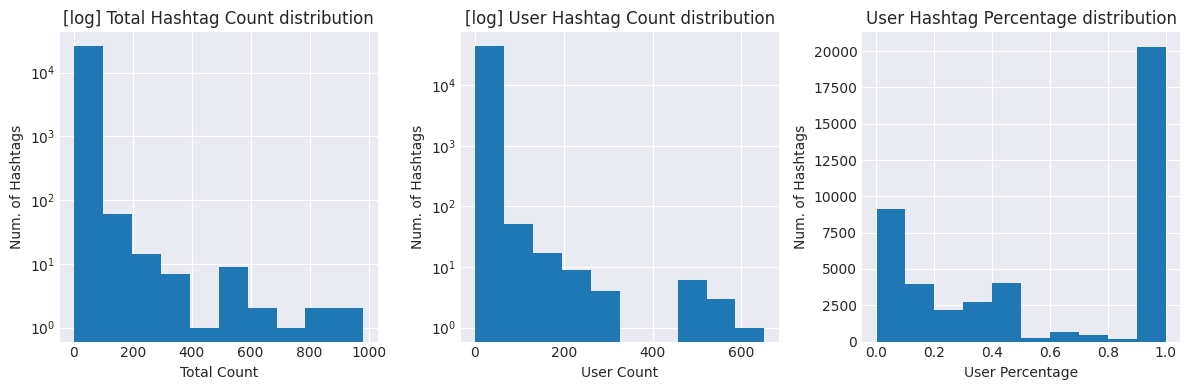

In [32]:
nrows = 1
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

total_hashtags = hashtags_groupby.groupby('hashtags').agg(
    total_hashtag_cnt=('user_hashtag_cnt', 'sum')
)

user_hashtags = hashtags_groupby.groupby(['hashtags', 'user_name']).agg(
    user_hashtag_cnt=('user_hashtag_cnt', 'sum')
)

total_hashtag_cnt_view = user_hashtags.groupby('hashtags').sum()
user_hashtags['total_hashtag_cnt'] = user_hashtags.index.to_series().apply(lambda x: total_hashtag_cnt_view.loc[x[0]])
user_hashtags['user_hashtag_pct'] = user_hashtags['user_hashtag_cnt'] / user_hashtags['total_hashtag_cnt']


total_hashtags.total_hashtag_cnt.hist(ax=axs[0], log=True)
axs[0].set_title('[log] Total Hashtag Count distribution')
axs[0].set_ylabel('Num. of Hashtags')
axs[0].set_xlabel('Total Count')
user_hashtags.user_hashtag_cnt.hist(ax=axs[1], log=True)
axs[1].set_title('[log] User Hashtag Count distribution')
axs[1].set_ylabel('Num. of Hashtags')
axs[1].set_xlabel('User Count')
user_hashtags.user_hashtag_pct.hist(ax=axs[2])
axs[2].set_title('User Hashtag Percentage distribution')
axs[2].set_ylabel('Num. of Hashtags')
axs[2].set_xlabel('User Percentage')

plt.tight_layout()
plt.show()

In [33]:
def normalize_hashtags_groupby(hashtags_gby):
    hashtags_gby['user_hashtag_cnt'] = hashtags_gby.apply(lambda row: 1 if row.user_hashtag_pct > 0.5 else row.user_hashtag_cnt, axis=1)
    hashtags_gby['is_retweet'] = hashtags_gby.apply(lambda row: 1 if row.user_hashtag_pct > 0.5 and row.is_retweet > 0 else row.is_retweet, axis=1)
    hashtags_gby['is_reply'] = hashtags_gby.apply(lambda row: 1 if row.user_hashtag_pct > 0.5 and row.is_reply > 0 else row.is_reply, axis=1)
    hashtags_gby['total_hashtag_cnt'] = hashtags_gby.index.to_series().apply(
        lambda x: hashtags_gby.loc[(x[0], x[1], x[2]), 'user_hashtag_cnt'].sum()
    )
    
    hashtags_gby['user_hashtag_pct'] = hashtags_gby['user_hashtag_cnt'] / hashtags_gby['total_hashtag_cnt']
    hashtags_gby['avg_user_hashtag_pct'] = hashtags_gby.index.to_series().apply(
        lambda x: hashtags_gby.loc[(x[0], x[1], x[2]), 'user_hashtag_pct'].mean()
    )
    return hashtags_gby


hashtags_groupby_1 = normalize_hashtags_groupby(hashtags_groupby)
# hashtags_groupby_1 = normalize_hashtags_groupby(hashtags_groupby_1)

In [ ]:
# hashtags_groupby_1.loc['SlavaUkraini'].sort_values('user_hashtag_share', ascending=False).head(30)

In [35]:
print("Hashtags per User, mean before transform: ", hashtags_groupby.user_hashtag_cnt.mean())
print("Hashtags per User, mean after transform: ", hashtags_groupby_1.user_hashtag_cnt.mean())

Hashtags per User, mean before transform:  1.4694787614042273
Hashtags per User, mean after transform:  1.4694787614042273


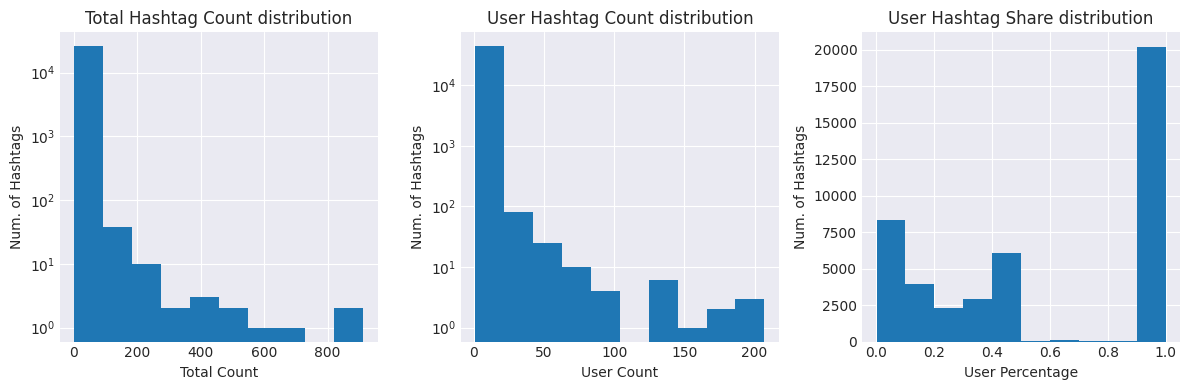

In [37]:
nrows = 1
ncols = 3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

total_hashtags = hashtags_groupby_1.groupby('hashtags').agg(
    total_hashtag_cnt=('user_hashtag_cnt', 'sum'),
    retweet_hashtag_cnt=('is_retweet', 'sum'),
    reply_hashtag_cnt=('is_reply', 'sum')
)
total_hashtags['original_hashtag_cnt'] = total_hashtags['total_hashtag_cnt'] - (total_hashtags['retweet_hashtag_cnt'] + total_hashtags['reply_hashtag_cnt'])

user_hashtags = hashtags_groupby_1.groupby(['hashtags', 'user_name']).agg(
    user_hashtag_cnt=('user_hashtag_cnt', 'sum')
)

total_hashtag_cnt_view = user_hashtags.groupby('hashtags').sum()
user_hashtags['total_hashtag_cnt'] = user_hashtags.index.to_series().apply(lambda x: total_hashtag_cnt_view.loc[x[0]])
user_hashtags['user_hashtag_share'] = user_hashtags['user_hashtag_cnt'] / user_hashtags['total_hashtag_cnt']


total_hashtags.total_hashtag_cnt.hist(ax=axs[0], log=True)
axs[0].set_title('Total Hashtag Count distribution')
axs[0].set_ylabel('Num. of Hashtags')
axs[0].set_xlabel('Total Count')
user_hashtags.user_hashtag_cnt.hist(ax=axs[1], log=True)
axs[1].set_title('User Hashtag Count distribution')
axs[1].set_ylabel('Num. of Hashtags')
axs[1].set_xlabel('User Count')
user_hashtags.user_hashtag_share.hist(ax=axs[2])
axs[2].set_title('User Hashtag Share distribution')
axs[2].set_ylabel('Num. of Hashtags')
axs[2].set_xlabel('User Percentage')

plt.tight_layout()
plt.show()

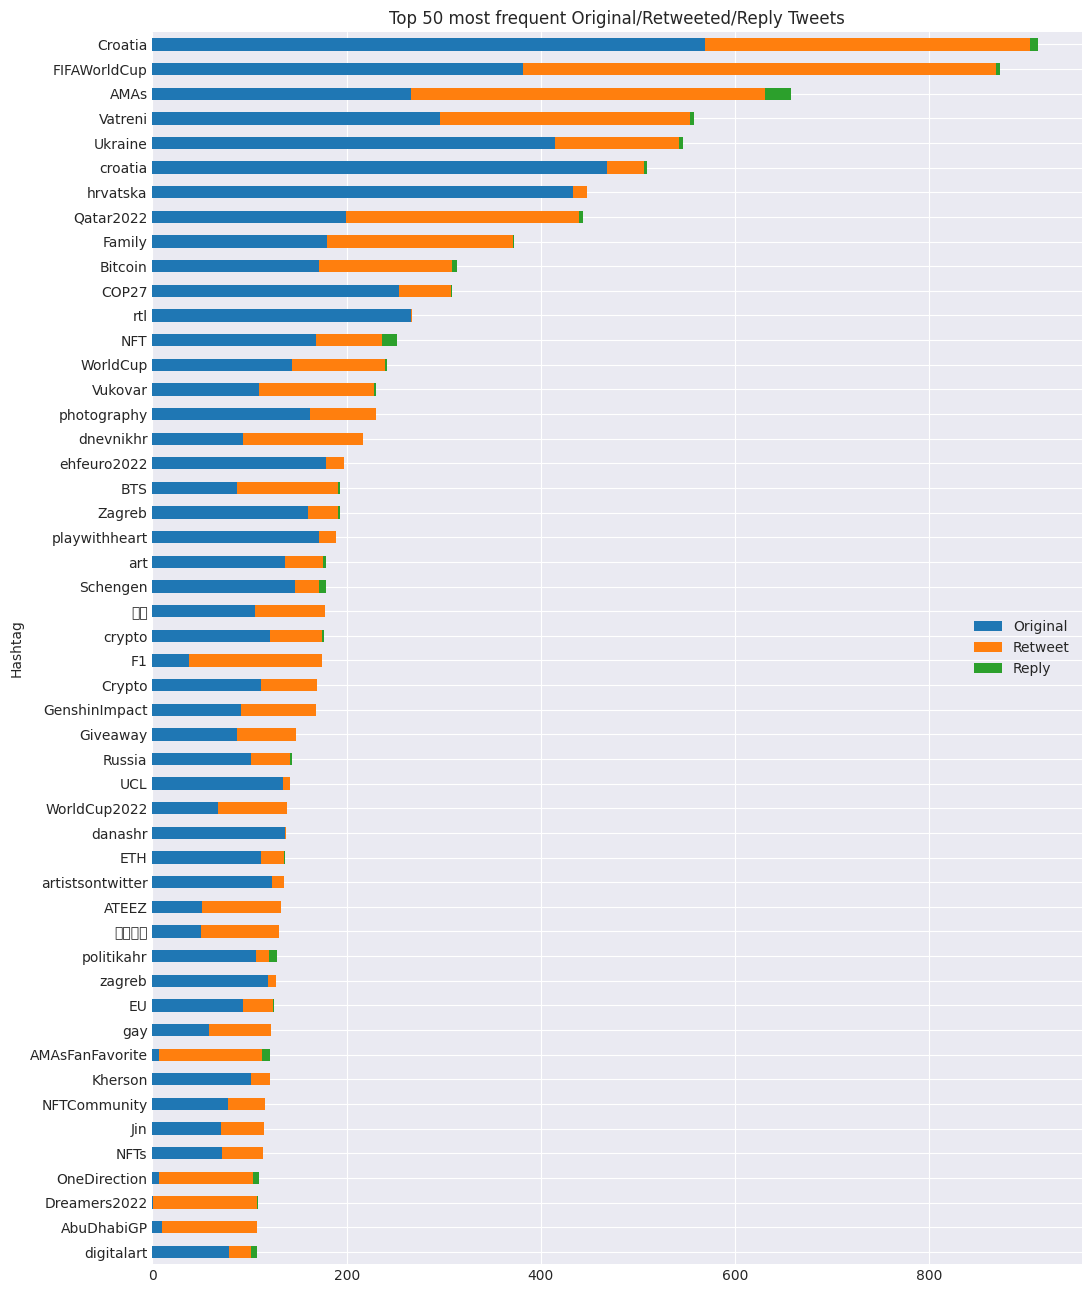

In [38]:
agg_hashtags_view = total_hashtags.sort_values('total_hashtag_cnt', ascending=False)
ax = agg_hashtags_view[['original_hashtag_cnt', 'retweet_hashtag_cnt', 'reply_hashtag_cnt']].rename(columns={
  'original_hashtag_cnt': 'Original',
  'retweet_hashtag_cnt': 'Retweet',
  'reply_hashtag_cnt': 'Reply'
}).head(50)[::-1].plot.barh(stacked=True, figsize=(12, 16))

ax.set_title('Top 50 most frequent Original/Retweeted/Reply Tweets')
ax.set_ylabel("Hashtag")
ax.legend(loc='center right')
plt.show()

## month + hashtags
  - What are the most frequently used hashtags on a monthly basis?

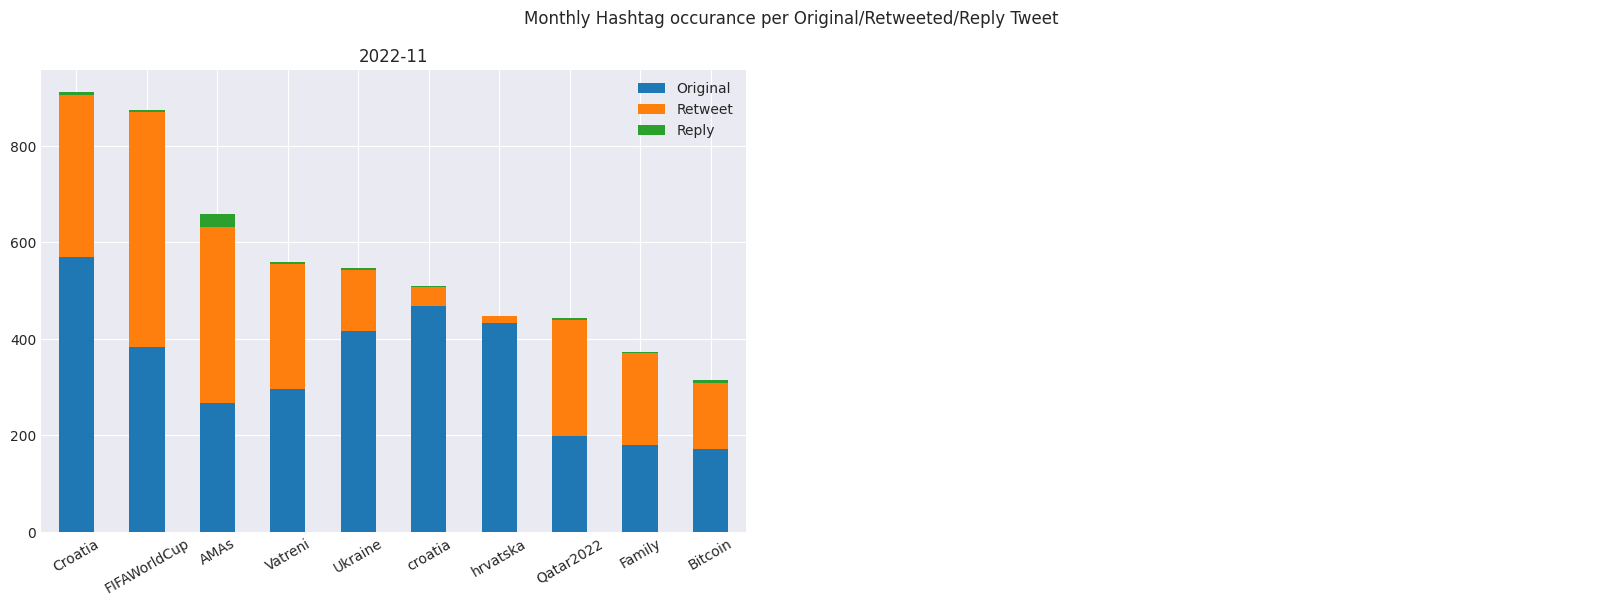

In [41]:
ncols = 2
nrows = ceil(len(unique_months) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*10, nrows*6), squeeze=False)
plt.suptitle("Monthly Hashtag occurance per Original/Retweeted/Reply Tweet")

month_hashtags = hashtags_groupby_1.groupby(['year', 'mon', 'hashtags']).agg(
    total_hashtag_cnt=('user_hashtag_cnt', 'sum'),
    retweet_hashtag_cnt=('is_retweet', 'sum'),
    reply_hashtag_cnt=('is_reply', 'sum')
).sort_values('total_hashtag_cnt', ascending=False)
month_hashtags['original_hashtag_cnt'] = month_hashtags['total_hashtag_cnt'] - (month_hashtags['retweet_hashtag_cnt'] + month_hashtags['reply_hashtag_cnt'])

month_hashtags = month_hashtags[['original_hashtag_cnt', 'retweet_hashtag_cnt', 'reply_hashtag_cnt']].rename(columns={
    'original_hashtag_cnt': 'Original',
    'retweet_hashtag_cnt': 'Retweet',
    'reply_hashtag_cnt': 'Reply'
})

i, j = 0, 0
for month in unique_months:
    if j == ncols: j = 0; i += 1
    
    year, mon = tuple(map(int, month.split('-')))
    plot_df = month_hashtags.loc[(year, mon)]
    plot_df.head(10).plot.bar(ax=axs[i][j], stacked=True, rot=30)
    axs[i][j].set_title(month)
    # ax.set_ylabel(month)
    axs[i][j].set_xlabel(None)
    j += 1

if len(unique_months) % 2 != 0:
    plt.axis('off')
plt.show()

## hashtags + user_id
  - What hashtags are linked to a user on average in total?
  - What hashtags are linked to a user on average on a monthly basis?

In [42]:
month_hashtags['Total'] = month_hashtags['Original'] + month_hashtags['Retweet'] + month_hashtags['Reply']

wordcloud_dict = {}
for year, mon, hashtag in month_hashtags.index:
    key = "{}-{}".format(year, str(mon).zfill(2))
    if key not in wordcloud_dict:
        wordcloud_dict[key] = []
    # print(year, mon, hashtag, month_hashtags.loc[(year, mon, hashtag), 'Total'])
    wordcloud_dict[key].append('{} '.format(hashtag) * int(month_hashtags.loc[(year, mon, hashtag), 'Total']))
wordcloud_dict = {key: " ".join(value) for key, value in wordcloud_dict.items()}

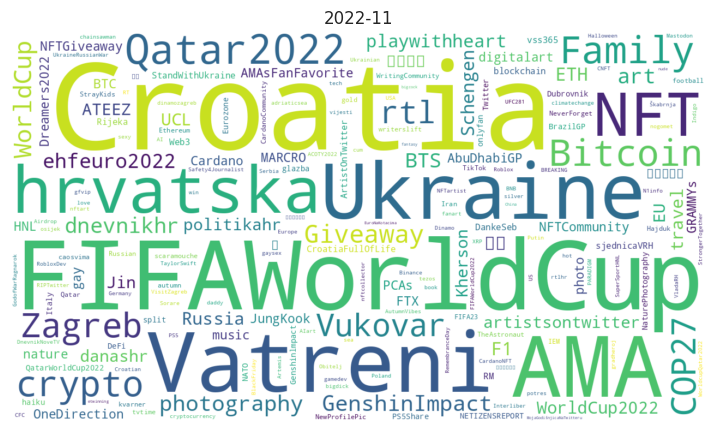

In [46]:
from wordcloud import WordCloud

fig, axs = plt.subplots(len(unique_months), figsize=(9, len(unique_months)*6), squeeze=False)

for i, month in enumerate(unique_months):
    wordcloud = WordCloud(collocations=False, background_color='white', width=1280, height=720, margin=10).generate(wordcloud_dict[month])
    axs[0][i].imshow(wordcloud, interpolation='bilinear')
    axs[0][i].set_title(month)
    axs[0][i].axis('off')
plt.show()

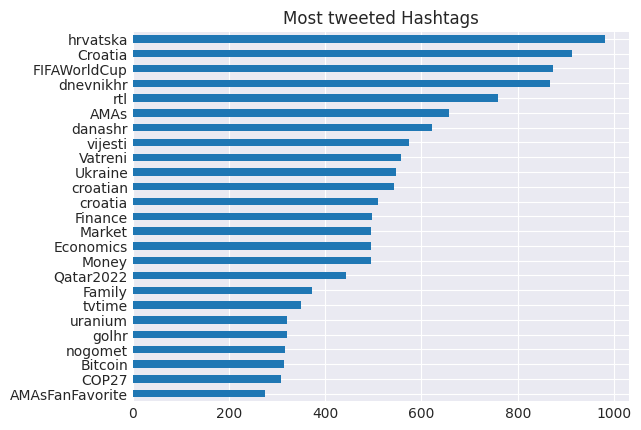

In [47]:
fig, ax = plt.subplots(1, figsize=None)

htag_count = tweets_view['hashtags'].explode().dropna().value_counts()
htag_count.head(25).iloc[::-1].plot.barh(ax=ax)

ax.set_title('Most tweeted Hashtags')
plt.show()

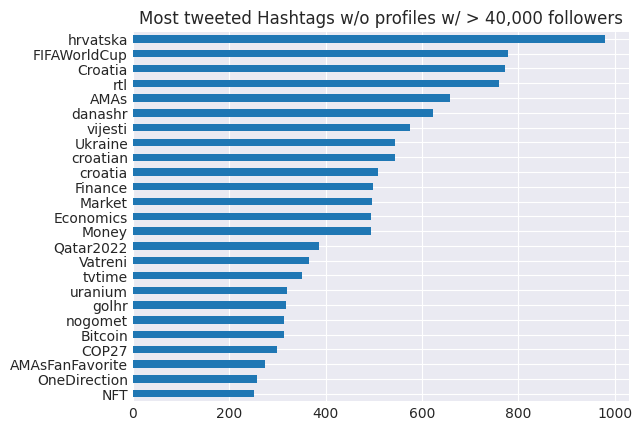

In [61]:
fig, ax = plt.subplots(1, figsize=None)

htag_count = tweets_view[tweets_view['user_followers_count'] < 40_000]['hashtags'].explode().dropna().value_counts()
htag_count.head(25).iloc[::-1].plot.barh(ax=ax)

ax.set_title('Most tweeted Hashtags w/o profiles w/ > 40,000 followers')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(9, 7))

ument_count = tweets_view[['user_id', 'user_mentions']].explode('user_mentions').dropna()
ument_count = ument_count.merge(users_df[['user_id', 'screen_name']], how='inner', on='user_id')
ument_count = ument_count.merge(users_df[['user_id', 'screen_name']], how='left', left_on='user_mentions', right_on='user_id', suffixes=['_source', '_target'])
ument_count = ument_count.groupby(['screen_name_source', 'screen_name_target']).size().sort_values(ascending=False)
ument_count.head(25).iloc[::-1].plot.barh(ax=ax)

ax.set_title('Most mentioned Users')
ax.set_ylabel('Source User to Mentioned User')
ax.set_yticklabels(["{} -- {}".format(src, tgt) for src, tgt in ument_count.head(25).iloc[::-1].index])
plt.show()